In [35]:
from pathlib import Path
from tqdm import tqdm
from einops import rearrange
from fdiff.utils.fourier import dft

import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

DATA_FILEPATH = Path.cwd() / "../data/nasdaq/stocks"

In [2]:
# Collate all stock data into a single dataframe
df_list = []
stock_paths = list(DATA_FILEPATH.glob("*.csv"))
for path in tqdm(stock_paths, unit="stock", leave=False, desc="Loading stock data"):
    df_stock = pd.read_csv(path)
    df_stock["Name"] = path.stem.strip(".csv")
    df_list.append(df_stock)
df = pd.concat(df_list, axis=0, ignore_index=True)
assert len(df["Name"].unique()) == len(stock_paths)
df.head()

Loading stock data:   0%|          | 0/5884 [00:00<?, ?stock/s]

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2015-10-12,0.050,0.050,0.050,0.050,0.050,0.0,LN
1,2015-10-13,0.045,0.045,0.045,0.045,0.045,5000.0,LN
2,2015-10-14,0.050,0.050,0.050,0.050,0.050,410000.0,LN
3,2015-10-15,0.050,0.050,0.050,0.050,0.050,91100.0,LN
4,2015-10-16,0.050,0.050,0.050,0.050,0.050,35000.0,LN


In [3]:
# Convert date column to datetime
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2015-10-12,0.050,0.050,0.050,0.050,0.050,0.0,LN
1,2015-10-13,0.045,0.045,0.045,0.045,0.045,5000.0,LN
2,2015-10-14,0.050,0.050,0.050,0.050,0.050,410000.0,LN
3,2015-10-15,0.050,0.050,0.050,0.050,0.050,91100.0,LN
4,2015-10-16,0.050,0.050,0.050,0.050,0.050,35000.0,LN


In [5]:
start_time = pd.to_datetime("2019-01-01")
end_time = pd.to_datetime("2020-01-01")

# Remove stocks that are not active in the whole time interval
stocks_older_than_start = set()
stocks_active_in_end = set()
for stock, valid in (df.groupby("Name")["Date"].min() <= start_time).items():
    if valid:
        stocks_older_than_start.add(stock)
for stock, valid in (df.groupby("Name")["Date"].max() >= end_time).items():
    if valid:
        stocks_active_in_end.add(stock)
valid_stocks = stocks_older_than_start.intersection(stocks_active_in_end)
df = df[
    df["Name"].isin(valid_stocks) & (df["Date"] >= start_time) & (df["Date"] < end_time)
]

In [6]:
# Remove stocks with missing days
stocks_no_missing_day = set()
for stock, valid in (df.groupby("Name")["Date"].nunique() == 252).items():
    if valid:
        stocks_no_missing_day.add(stock)
df = df[df["Name"].isin(stocks_no_missing_day)]

In [7]:
df.groupby("Name")["Date"].nunique().value_counts()

Date
252    5364
Name: count, dtype: int64

In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
809,2019-01-02,33.590000,34.320000,33.590000,34.160000,34.160000,25900.0,LN
810,2019-01-03,34.209999,34.439999,33.490002,33.529999,33.529999,72200.0,LN
811,2019-01-04,35.060001,36.340000,35.009998,36.340000,36.340000,81800.0,LN
812,2019-01-07,36.160000,36.459999,35.880001,36.150002,36.150002,47600.0,LN
813,2019-01-08,36.330002,36.639999,36.070000,36.580002,36.580002,48700.0,LN


In [12]:
df_pivot = df.pivot_table(
    index="Name",
    columns="Date",
    values=["Open", "High", "Low", "Close", "Adj Close", "Volume"],
)
df_pivot.head()

Adj Close                                                         \
Date 2019-01-02 2019-01-03 2019-01-04 2019-01-07 2019-01-08 2019-01-09   
Name                                                                     
A     64.968681  62.575249  64.741203  66.115929  67.085175  68.489578   
AA    26.240000  26.240000  28.340000  28.420000  28.250000  29.100000   
AAL   31.963160  29.581665  31.530161  32.425678  31.904110  32.888199   
AAMC  30.010000  30.309999  29.760000  29.730000  29.080000  29.389999   
AAME   2.470238   2.628968   2.926587   2.748016   2.628968   2.767857   

                                                  ...     Volume             \
Date 2019-01-10 2019-01-11 2019-01-14 2019-01-15  ... 2019-12-17 2019-12-18   
Name                                              ...                         
A     69.132446  69.607170  68.984100  69.824745  ...  1653200.0  2025500.0   
AA    28.980000  28.549999  28.790001  28.900000  ...  3504000.0  5129800.0   
AAL   31.530161  31.293980  31.205410  31.589205  ...  5920300.0  4633800.0   
AAMC  29.600000  30.490000  30.570000  29.920000  ...     3700.0     6800.0   
AAME   2.430556   2.579365   2.470238   2.648810  ...     4000.0    10900.0   

                                                                         \
Date 2019-12-19  2019-12-20 2019-12-23 2019-12-24 2019-12-26 2019-12-27   
Name                                                                      
A     1696000.0   2287800.0   816000.0   271900.0   649100.0   767700.0   
AA    4766900.0   5139800.0  2262200.0  1092200.0  4729200.0  2455000.0   
AAL   6295100.0  12277100.0  9291100.0  2373600.0  4746500.0  8416500.0   
AAMC    12000.0         0.0      600.0     6900.0      300.0        0.0   
AAME     3600.0      5100.0     1000.0     1700.0     5900.0     3500.0   

                            
Date 2019-12-30 2019-12-31  
Name                        
A      742800.0  1176200.0  
AA    2299200.0  2288500.0  
AAL   4940300.0  4396800.0  
AAMC    20100.0    21500.0  
AAME      700.0     3400.0  

[5 rows x 1512 columns]

In [25]:
# Create a tensor of shape (num_stocks, num_days, num_features) from df
X = torch.tensor(df_pivot.values, dtype=torch.float32)
X = rearrange(X, "stock (feature day) -> stock day feature", day=252)
X.shape

torch.Size([5364, 252, 6])

In [30]:
for stock in range(5):
    print(X[stock, :, 0:5])

tensor([[64.9687, 65.6900, 66.5700, 65.3000, 66.5000],
        [62.5752, 63.2700, 65.7800, 62.0000, 65.5300],
        [64.7412, 65.4600, 65.9500, 64.0900, 64.0900],
        ...,
        [85.0236, 85.4200, 85.6800, 85.1100, 85.6800],
        [84.6845, 84.9000, 85.4000, 84.6400, 85.3400],
        [85.0934, 85.3100, 85.3400, 84.6700, 84.8400]])
tensor([[26.2400, 26.2400, 26.8470, 25.4800, 25.9550],
        [26.2400, 26.2400, 26.8500, 25.5300, 26.1200],
        [28.3400, 28.3400, 28.6100, 26.6500, 26.8400],
        ...,
        [21.5800, 21.5800, 21.7800, 21.3300, 21.4100],
        [21.3400, 21.3400, 21.7000, 21.3000, 21.7000],
        [21.5100, 21.5100, 21.6700, 21.2600, 21.3700]])
tensor([[31.9632, 32.4800, 32.6500, 31.0500, 31.4600],
        [29.5817, 30.0600, 31.8500, 28.8100, 31.6900],
        [31.5302, 32.0400, 32.0900, 30.4000, 30.4400],
        ...,
        [28.3353, 28.4400, 29.8100, 28.3600, 29.7600],
        [28.1958, 28.3000, 28.5300, 28.0700, 28.5000],
        [28.5744, 28.680

In [32]:
train_ratio = 0.9
num_train = int(train_ratio * len(X))
perm_idx = torch.randperm(len(X))
train_stocks, test_stocks = perm_idx[:num_train], perm_idx[num_train:]
X_train, X_test = X[train_stocks], X[test_stocks]
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: torch.Size([4827, 252, 6])
Test set shape: torch.Size([537, 252, 6])


/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

Text(0, 0.5, 'Singular value')

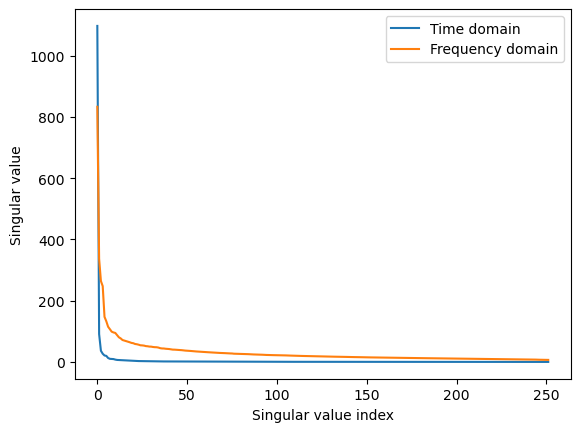

In [48]:
import matplotlib.pyplot as plt

X_train_reduced = X_train[:, :, :1]
X_norm = (
    X_train_reduced - X_train_reduced.mean(dim=0, keepdim=True)
) / X_train_reduced.std(dim=0, keepdim=True)
X_dft = dft(X_train_reduced)
X_norm_dft = (X_dft - X_dft.mean(dim=0, keepdim=True)) / X_dft.std(dim=0, keepdim=True)

sns.lineplot(torch.svd(X_norm.flatten(start_dim=1))[1], label="Time domain")
sns.lineplot(torch.svd(X_norm_dft.flatten(start_dim=1))[1], label="Frequency domain")
plt.legend()
plt.xlabel("Singular value index")
plt.ylabel("Singular value")

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


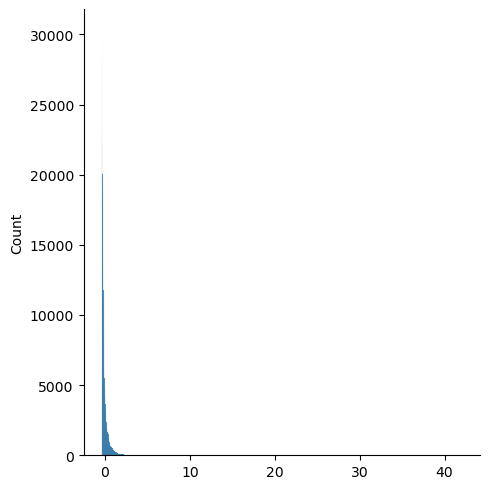

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


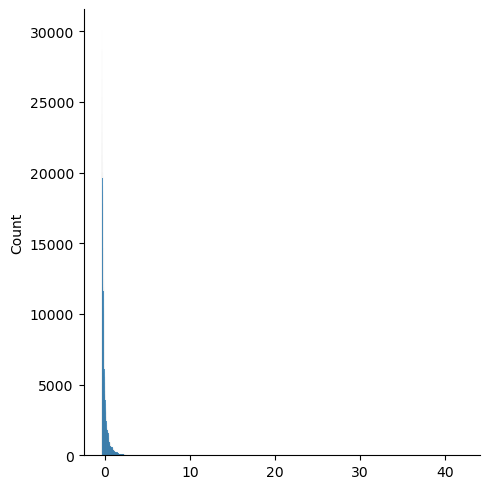

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


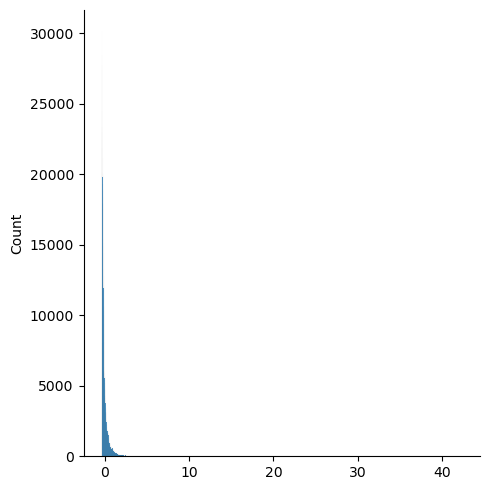

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


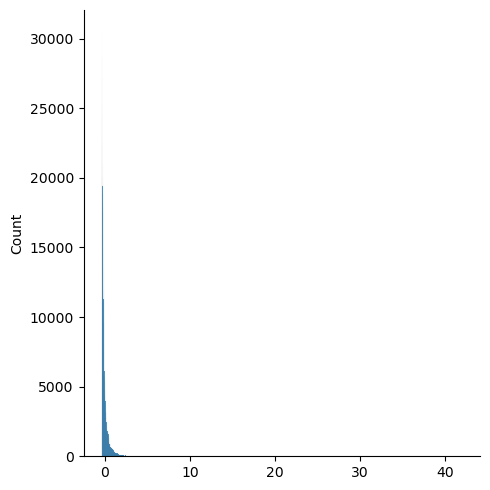

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


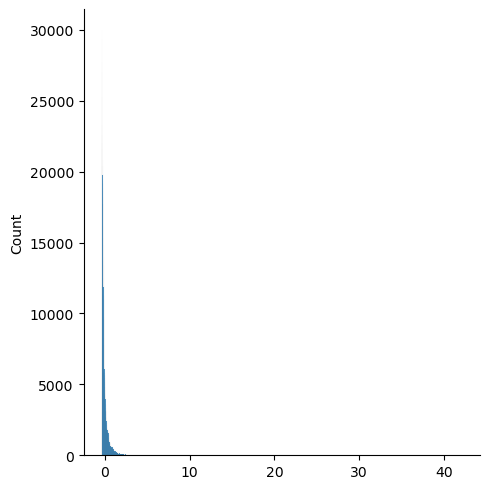

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


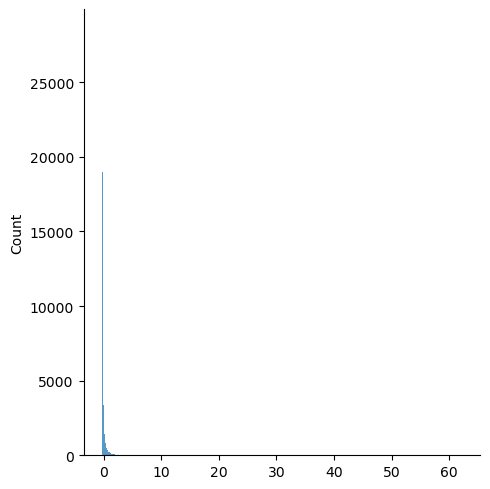

In [45]:
for i in range(6):
    sns.displot(X_norm[:, :, i].flatten())
    plt.show()

In [55]:
X_norm.std(dim=0)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1

In [56]:
df.max()

Date         2019-12-31 00:00:00
Open                      4712.0
High                 4743.709961
Low                  4651.029785
Close                     4699.0
Adj Close            4688.308594
Volume               432720700.0
Name                        ZYXI
dtype: object

In [57]:
df.min()

Date         2019-01-02 00:00:00
Open                       0.004
High                       0.004
Low                       0.0003
Close                      0.003
Adj Close                  0.003
Volume                       0.0
Name                           A
dtype: object